# Hypothesis testing

Water Data & Statistics | Waterhackweek 2020 | Steven Pestana (spestana@uw.edu)

The material in this notebook is derived from UW Civil & Enviro Engineering course material [Data Analysis in Water Science](https://mountain-hydrology-research-group.github.io/data-analysis) and the USGS book [Statistical Methods in Water Resources](https://pubs.er.usgs.gov/publication/tm4A3).

---

In [1]:
import numpy as np
import pandas as pd

# scipy statistics package
import scipy.stats as st

# for plotting
import matplotlib.pyplot as plt
# tell jupyter to show our plots in the notebook here
%matplotlib inline

The Skykomish River in Washington state appears to have had a change in streamflow around the year 1970. 

Let's load the streamflow data and then test if there's a statistically significant change.

In [2]:
# Filepath to our excel file.
skykomish_data_file = 'data/Skykomish_peak_flow_12134500_skykomish_river_near_gold_bar.xlsx'

# Use pandas.read_excel() function to open this file.
skykomish_data = pd.read_excel(skykomish_data_file)

# Now we can see the dataset we loaded:
skykomish_data.head(3)

,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08


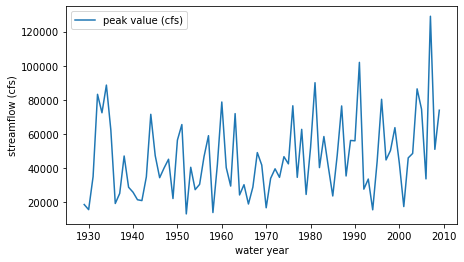

In [3]:
# Plot peak streamflows per water year
fig, ax = plt.subplots(figsize=(7,4))

skykomish_data.plot(x='water year', y='peak value (cfs)', ax=ax)

ax.set_ylabel('streamflow (cfs)');

---
Question: Considering the peak flow time series for Skykomish River, we are postulating that there was an **increase in peak flows** around 1970.

**We'll want to test for statistical significance of the observed change in the mean peak flow before/after 1970**. 

In other words, how likely is it that the mean of peak flows before 1970 comes from the same "distribution" as the mean of peak flows after 1970?

To start, let's split the data in two:

In [4]:
# Divide the data into the early period (before 1970) and late period (after and including 1970). 

skykomish_before = skykomish_data[ skykomish_data['water year'] < 1970 ]
skykomish_after = skykomish_data[ skykomish_data['water year'] >= 1970 ]

In [5]:
skykomish_after.head(3)

,date of peak,water year,peak value (cfs),gage_ht (feet)
41,1970-06-03,1970,16900,10.52
42,1971-01-19,1971,34100,14.06
43,1972-02-28,1972,39700,15.00


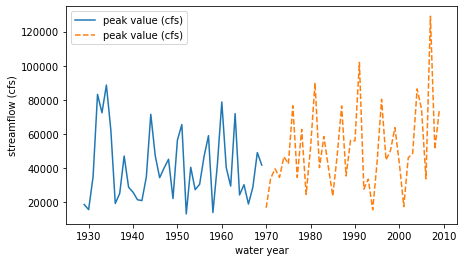

In [6]:
# Plot our two time periods
fig, ax = plt.subplots(figsize=(7,4))

skykomish_before.plot(x='water year', y='peak value (cfs)', ax=ax, linestyle='-')
skykomish_after.plot(x='water year', y='peak value (cfs)', ax=ax, linestyle='--')

ax.set_ylabel('streamflow (cfs)');

**What does the distribution of streamflows in each period look like?**

Plot a histogram for each period:

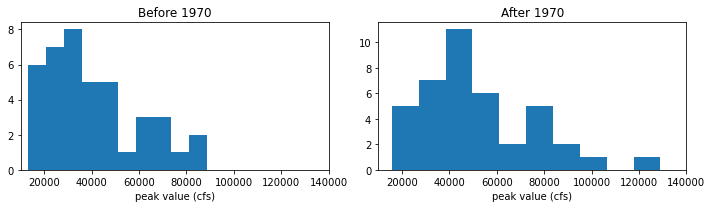

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax1.hist(skykomish_before['peak value (cfs)'], bins=10)
ax1.set_xlim((1e4,1.4e5))
ax1.set_xlabel('peak value (cfs)')
ax1.set_title('Before 1970')

ax2.hist(skykomish_after['peak value (cfs)'], bins=10)
ax2.set_xlim((1e4,1.4e5))
ax2.set_xlabel('peak value (cfs)')
ax2.set_title('After 1970');

plt.tight_layout()

---

What kind of hypothesis test should we use here? Let's consult the experts! (Table 4.1 in *Statistical Methods in Water Resources* is very helpful)

<img src="table4-1.JPG" alt="Table 4.1 from Statistical Methods in Water Resources">

It looks like we should be using a t-test, however if we read further we'll find that in this case we can use the z-test variation where we use the standard deviation of our two sets of data rather than assuming that they are the same. (Wikipedia has good explanations about the [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test) and [z-test](https://en.wikipedia.org/wiki/Z-test))

First we can formally state our null hypothesis, and our alternative hypothesis.

Our null hypothesis is that the peak flows of the early period are drawn from the same distribution as the peak flows of the later period (the distributions means are equal):

$H_0: \mu_{early} = \mu_{late}$

Our alternative hypothesis is that the mean of the distribution for the later period is greater than that of the early period:

$H_1: \mu_{late} > \mu_{early}$


This is a "[one-sided](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests)" test because we are testing only for a change in one direction.
We'll be using the [z-test](https://en.wikipedia.org/wiki/Z-test), which uses a standard-normal distribution. From our work above, we know that our data are _not_ normally distributed.
However, the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) states, "*If a sample of n values is extracted at random from a population with mean  μ and standard deviation σ, and n > 30, then the means of these samples are approximately normally distributed*"

$\displaystyle Z={\frac {({\bar {X}}-\mu _{0})}{s}}$

(See [Statistical Methods in Water Resources](https://pubs.er.usgs.gov/publication/tm4A3) from the USGS for more info about using the z-test in a case like this)

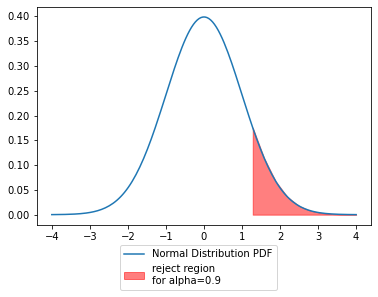

In [8]:
fig, ax = plt.subplots()
# Create a null pdf
x = np.linspace(-4, 4, num=160)
ax.plot(x, st.norm.pdf(x, 0, 1), label='Normal Distribution PDF')
# Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
conf = 0.90
z_alpha = st.norm.ppf(conf)
shade = np.linspace(z_alpha, 4, 10)
ax.fill_between(shade, st.norm.pdf(shade, 0, 1) ,  color='red', alpha=0.5, label='reject region\nfor alpha={}'.format(conf))
ax.legend(loc=(0.25,-0.3));

Check that we have a large enough sample size for each set (n>30)

In [9]:
n = len(skykomish_before['peak value (cfs)'])
m = len(skykomish_after['peak value (cfs)'])

print(n, m)

41 40


Pick our confidence level:

In [10]:
# if alpha is set at 0.05, the confidence is 1-alpha:
conf = 0.95

Our null hypothesis is no change, where  $\mu_{early} - \mu_{late} = 0$

In [11]:
delta_0 = 0

Determine which value in the z-distribution corresponds to 0.95 in the cumulative density function. This is the value our z_test would have to exceed in order to reject the null hypothesis.

In [12]:
z_alpha = st.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

z_alpha = 1.6448536269514722


Now calculate the z-test value, and p-value.

In [13]:
mean1 = np.mean(skykomish_before['peak value (cfs)'])
mean2 = np.mean(skykomish_after['peak value (cfs)'])

sd1 = np.std(skykomish_before['peak value (cfs)'])
sd2 = np.std(skykomish_after['peak value (cfs)'])

# Calculate the "pooled standard deviation"
pooled_sd = np.sqrt(sd1**2/n + sd2**2/m)

# Calculate z_test
z_test = (mean2 - mean1 - delta_0)/pooled_sd
print("z_test = {}".format(z_test)) 

# Calculate our p-value
p = 1 - st.norm.cdf(z_test)
print("p = {}".format(p))

z_test = 2.1651957458526456
p = 0.015186348999318366


So what does this mean?

The z_test value does exceed the z_alpha value, meaning that with 95% confidence there was a statistically significant change in peak flows around 1970.

The p-value tells us that we can go down to an alpha of about 0.015 before it is no longer a statistically significant change (i.e. confidence = 98.5%)

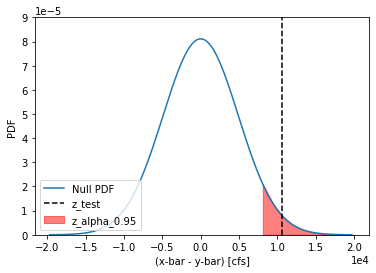

In [14]:
# Plot the results
fig, ax = plt.subplots()

# Create the null pdf (normally distributed located at zero with pooled_sd)
x = np.linspace(-4, 4, num=160)
x = [i * pooled_sd for i in x]

ax.plot(x, st.norm.pdf(x, 0, pooled_sd), label='Null PDF')

# Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
shade = np.linspace(z_alpha*pooled_sd, 2e4, 10)
ax.fill_between(shade, st.norm.pdf(shade, 0, pooled_sd) ,  color='red', alpha=0.5, label='z_alpha_{}'.format(conf))

# Plot z_test
ax.axvline(z_test*pooled_sd, color='k', linestyle='--', label='z_test')

ax.set_xlabel('(x-bar - y-bar) [cfs]')
ax.set_ylabel('PDF')

ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.set_ylim(0, 9e-5)
ax.legend(loc='lower left');

---
**But what if we tried to test with a 99% confidence interval?**

In [15]:
# if alpha is set at 0.01, the confidence is 1-alpha:
conf = 0.99

# Our null hypothesis of no change
delta_0 = 0

# Determine which value in the z-distribution corresponds to 0.99 in the cdf
z_alpha = st.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

# Calculate z_test
z_test = (mean2 - mean1 - delta_0)/pooled_sd
print("z_test = {}".format(z_test)) 

# Calculate our p-value
p = 1 - st.norm.cdf(z_test)
print("p = {}".format(p))

z_alpha = 2.3263478740408408
z_test = 2.1651957458526456
p = 0.015186348999318366


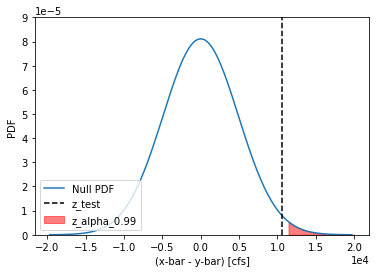

In [16]:
# Plot the results
fig, ax = plt.subplots()

# Create the null pdf (normally distributed located at zero with pooled_sd)
x = np.linspace(-4, 4, num=160)
x = [i * pooled_sd for i in x]

ax.plot(x, st.norm.pdf(x, 0, pooled_sd), label='Null PDF')

# Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
shade = np.linspace(z_alpha*pooled_sd, 2e4, 10)
ax.fill_between(shade, st.norm.pdf(shade, 0, pooled_sd) ,  color='red', alpha=0.5, label='z_alpha_{}'.format(conf))

# Plot z_test
ax.axvline(z_test*pooled_sd, color='k', linestyle='--', label='z_test')

ax.set_xlabel('(x-bar - y-bar) [cfs]')
ax.set_ylabel('PDF')

ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax.set_ylim(0, 9e-5)
ax.legend(loc='lower left');

We can see in fact that at 99% confidence, there is not a statistically significant change here.